In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import os
import h5py
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

# Load embeddings and align classes

In [2]:
embeddings = h5py.File('embeddings.h5', 'r')

def printname(name):
    print(name)
embeddings.visit(printname)

irmas
irmas/openl3
irmas/openl3/features
irmas/openl3/keys
irmas/vggish
irmas/vggish/features
irmas/vggish/keys
openmic
openmic/openl3
openmic/openl3/features
openmic/openl3/keys
openmic/vggish
openmic/vggish/features
openmic/vggish/keys


In [3]:
with open('class-map-10.json', 'r') as f: # only consider 10 classes of Openmic dataset
    class_map = json.load(f)
    
class_map

{'cello': 3,
 'clarinet': 4,
 'flute': 7,
 'guitar': 8,
 'organ': 11,
 'piano': 12,
 'saxophone': 13,
 'trumpet': 16,
 'violin': 18,
 'voice': 19}

In [4]:
# use a dict to align the classes between Openmic dataset (key) and Irmas dataset (val)
class_align = {'cello': 'cel',
               'clarinet': 'cla',
               'flute': 'flu',
               'guitar': ['gac', 'gel'],
               'organ': 'org',
               'piano': 'pia',
               'saxophone': 'sax',
               'trumpet': 'tru',
               'violin': 'vio',
               'voice': 'voi'}

In [5]:
# use a Pandas DataFrame to record all results and save into a csv file later
result_all = pd.DataFrame({'instrument': [],
                          'train_set': [],
                          'test_set': [],
                          'precision': [],
                          'recall': [],
                          'f1-score': [],
                          'support': [],
                          'accuracy': [],
                          'roc_auc': [],
                          'ap': []
                         })

# irmas->irmas

In [6]:
# irmas: Vggish embedding
feature = np.array(embeddings['irmas']['vggish']['features'])
keys_ori = np.array(embeddings['irmas']['vggish']['keys'])
print(feature.shape, keys_ori.shape)

key_clip = np.unique(keys_ori)
print(key_clip.shape)

(13410, 128) (13410,)
(6705,)


In [7]:
key_clip

array(['001__[gel][dru][pop_roc]0829__1',
       '001__[gel][dru][pop_roc]0829__2',
       '001__[gel][dru][pop_roc]0829__3', ..., '[voi][pop_roc]2548__1',
       '[voi][pop_roc]2548__2', '[voi][pop_roc]2548__3'], dtype=object)

In [8]:
feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys_ori[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

  0%|          | 0/6705 [00:00<?, ?it/s]

(6705, 128) (6705,)


In [9]:
key_train = list(pd.read_csv('irmas_train.csv', header=None, squeeze=True))
key_test = list(pd.read_csv('irmas_test.csv', header=None, squeeze=True))

key_train = np.array([k[2:-1] for k in key_train])
key_test = np.array([k[2:-1]  for k in key_test])

In [10]:
# these loops go through all sample keys, and save their row numbers to either idx_train or idx_test
idx_train, idx_test = [], []

for k in range(len(key_clip)):
    if str(key_clip[k]) in key_train:
        idx_train.append(k)
    elif str(key_clip[k]) in key_test:
        idx_test.append(k)
    else:
        # This should never happen, but better safe than sorry.
        raise RuntimeError('Unknown sample key={}! Abort!'.format(str(key_clip[k])))
        
# cast the idx_* arrays to numpy structures
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [11]:
#keys = np.array([str(k, encoding='utf-8') for k in key_clip])
keys = np.array(key_clip)
keys = [key[key.index('[')+1:key.index(']')] for key in keys]

for key in class_align:
    keys = [key if x in class_align[key] else x for x in keys]
    
keys = np.array(keys)
np.unique(keys)

array(['cello', 'clarinet', 'flute', 'guitar', 'organ', 'piano',
       'saxophone', 'trumpet', 'violin', 'voice'], dtype='<U9')

In [12]:
# use the split indices to partition the features, labels, and masks
X_train = feature_clip[idx_train,:]
X_test = feature_clip[idx_test]

Y_true_train = keys[idx_train]
Y_true_test = keys[idx_test]

# print out the sliced shapes as a sanity check
print(X_train.shape)
print(X_test.shape)

(5039, 128)
(1666, 128)


In [13]:
############################# project the LDA direction #############################
embedding_name = 'vggish'
file = open('LDA_' + embedding_name + '_coef.pickle', 'rb')
globals()['LDA_coef_' + embedding_name] = pickle.load(file)
file.close()

v = globals()['LDA_coef_' + embedding_name]
v /= np.sqrt(np.sum(v**2))
A = np.outer(v, v)

Xdeb_train = X_train.dot(np.eye(len(A)) - A)
Xdeb_test = X_test.dot(np.eye(len(A)) - A)
print(Xdeb_train.shape, Xdeb_test.shape)

X_train = Xdeb_train; X_test = Xdeb_test; del(Xdeb_train, Xdeb_test)
print(X_train.shape, X_test.shape)

(5039, 128) (1666, 128)
(5039, 128) (1666, 128)


In [14]:
train_set_name, test_set_name = 'irmas', 'irmas'

# use a dictionary to include the classifier for each instrument trained on the dataset based on the embedding
globals()['models_'+train_set_name] = dict()  

# iterate over all istrument classes, and fit a model for each one
for instrument in class_align:
    
    # get the training and testing labels for each instrument
    Y_true_train_inst = Y_true_train==instrument
    Y_true_test_inst = Y_true_test==instrument
    
    # initialize and a logistic regression model
    LRmodel = LogisticRegression(random_state=0, penalty='l2', solver='liblinear', class_weight='balanced')
    
    # hyperparameter tunning for logistic regression model
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100] }  
    scoring = 'roc_auc'; cv = 3
    clf =  GridSearchCV(LRmodel, param_grid=param_grid, cv=cv, scoring=scoring)  
    
    # fit the model
    clf.fit(X_train, Y_true_train_inst)
    
    # predict
    Y_pred_test_inst = clf.predict(X_test)
    
    # Get prediction scores for the positive class
    Y_pred_test_scores = clf.predict_proba(X_test)[:, 1]
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test_inst))
    
    model_auc = roc_auc_score(Y_true_test_inst, Y_pred_test_scores)
    model_ap = average_precision_score(Y_true_test_inst, Y_pred_test_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # store the classifier in the model dictionary
    globals()['models_'+train_set_name][instrument] = clf
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    
    report_accuracy = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap]
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.99      0.88      0.93      1572
        True       0.30      0.85      0.44        94

    accuracy                           0.88      1666
   macro avg       0.64      0.87      0.69      1666
weighted avg       0.95      0.88      0.90      1666

ROC-AUC = 0.925		AP = 0.622
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.98      0.85      0.91      1539
        True       0.30      0.77      0.43       127

    accuracy                           0.85      1666
   macro avg       0.64      0.81      0.67      1666
weighted avg       0.93      0.85      0.88      1666

ROC-AUC = 0.880		AP = 0.534
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.98      0.87    

# openmic->openmic

In [15]:
# openmic: vggish embedding
feature = np.array(embeddings['openmic']['vggish']['features'])
keys = np.array(embeddings['openmic']['vggish']['keys'])
print(feature.shape, keys.shape)

key_clip = np.unique(keys)
key_clip.shape

(180000, 128) (180000,)


(20000,)

In [16]:
feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

#key_clip = np.array([str(k, 'utf-8') for k in key_clip])
key_clip = np.array(key_clip)
key_clip

  0%|          | 0/20000 [00:00<?, ?it/s]

(20000, 128) (20000,)


array(['000046_3840', '000135_483840', '000139_119040', ...,
       '155307_211200', '155310_372480', '155311_453120'], dtype=object)

In [18]:
# key-label map using the information from the dataset source
data_root = '/import/c4dm-datasets/openmic-2018/openmic-2018/'
# Replaced the above by a local symbolic link within the github repo
# data_root = 'openmic-2018/'

np_load_old = np.load   # save np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True,**k)   # modify the default parameters of np.load

Ytrue = np.load(os.path.join(data_root, 'openmic-2018.npz'))['Y_true']
Ymask = np.load(os.path.join(data_root, 'openmic-2018.npz'))['Y_mask']
sample_key = np.load(os.path.join(data_root, 'openmic-2018.npz'))['sample_key']

np.load = np_load_old   # restore np.load for future normal usage
del(np_load_old)

print(Ytrue.shape, Ymask.shape, sample_key.shape)

(20000, 20) (20000, 20) (20000,)


In [19]:
Y_true = []
Y_mask = []

for key in tqdm(key_clip):
    Y_true.append(Ytrue[sample_key==key])
    Y_mask.append(Ymask[sample_key==key])
    
Y_true = np.squeeze(np.array(Y_true))
Y_mask = np.squeeze(np.array(Y_mask))

X = feature_clip
del(feature_clip)

print(X.shape, Y_true.shape, Y_mask.shape)

  0%|          | 0/20000 [00:00<?, ?it/s]

(20000, 128) (20000, 20) (20000, 20)


In [20]:
# train-test split
split_train = pd.read_csv('openmic2018_train.csv', header=None, squeeze=True)
split_test = pd.read_csv('openmic2018_test.csv', header=None, squeeze=True)

print('# Train: {},  # Test: {}'.format(len(split_train), len(split_test)))

train_set = set(split_train)
test_set = set(split_test)

# Train: 14915,  # Test: 5085


In [21]:
idx_train, idx_test = [], []

for idx, n in enumerate(key_clip):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
    else:
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[n]))
        
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [22]:
X_train = X[idx_train]
X_test = X[idx_test]

Y_true_train = Y_true[idx_train]
Y_true_test = Y_true[idx_test]

Y_mask_train = Y_mask[idx_train]
Y_mask_test = Y_mask[idx_test]

print(X_train.shape); print(X_test.shape)

(14915, 128)
(5085, 128)


In [23]:
Xdeb_train = X_train.dot(np.eye(len(A)) - A)
Xdeb_test = X_test.dot(np.eye(len(A)) - A)
print(Xdeb_train.shape, Xdeb_test.shape)

X_train = Xdeb_train; X_test = Xdeb_test; del(Xdeb_train, Xdeb_test)
print(X_train.shape, X_test.shape)

(14915, 128) (5085, 128)
(14915, 128) (5085, 128)


In [24]:
# This part of the code follows the baseline model for instrument recognition on the openmic dataset:
# https://github.com/cosmir/openmic-2018/blob/master/examples/modeling-baseline.ipynb
train_set_name, test_set_name = 'openmic', 'openmic'

# use a dictionary to include the classifier for each instrument trained on the dataset based on the embedding
globals()['models_'+train_set_name] = dict()  

# We'll iterate over all istrument classes, and fit a model for each one
# After training, we'll print a classification report for each instrument
for instrument in class_align:
    
    # Map the instrument name to its column number
    inst_num = class_map[instrument]
    
    # First, sub-sample the data: we need to select down to the data for which we have annotations
    # This is what the mask arrays are for
    train_inst = Y_mask_train[:, inst_num]
    test_inst = Y_mask_test[:, inst_num]
    
    # Here, we're using the Y_mask_train array to slice out only the training examples
    # for which we have annotations for the given class
    X_train_inst = X_train[train_inst]
    
    # Again, we slice the labels to the annotated examples
    # We thresold the label likelihoods at 0.5 to get binary labels
    Y_true_train_inst = Y_true_train[train_inst, inst_num] >= 0.5
    
    # Repeat the above slicing and dicing but for the test set
    X_test_inst = X_test[test_inst]
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= 0.5

    # initialize and a logistic regression model
    LRmodel = LogisticRegression(random_state=0, penalty='l2', solver='liblinear', class_weight='balanced')
    
    # hyperparameter tunning for logistic regression model
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100] }  
    scoring = 'roc_auc'; cv = 3
    clf =  GridSearchCV(LRmodel, param_grid=param_grid, cv=cv, scoring=scoring)    
    
    # fit the model
    clf.fit(X_train_inst, Y_true_train_inst)

    # predict
    Y_pred_test_inst = clf.predict(X_test_inst)
    # Get prediction scores for the positive class
    Y_pred_test_scores = clf.predict_proba(X_test_inst)[:, 1]
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test_inst))
    
    model_auc = roc_auc_score(Y_true_test_inst, Y_pred_test_scores)
    model_ap = average_precision_score(Y_true_test_inst, Y_pred_test_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # store the classifier in the model dictionary
    globals()['models_'+train_set_name][instrument] = clf
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    report_accuracy = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.83      0.75      0.78       259
        True       0.74      0.82      0.78       226

    accuracy                           0.78       485
   macro avg       0.78      0.78      0.78       485
weighted avg       0.79      0.78      0.78       485

ROC-AUC = 0.866		AP = 0.820
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.89      0.66      0.76       503
        True       0.36      0.71      0.48       137

    accuracy                           0.67       640
   macro avg       0.63      0.68      0.62       640
weighted avg       0.78      0.67      0.70       640

ROC-AUC = 0.748		AP = 0.438
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.85      0.66    

# irmas->openmic

In [25]:
train_set_name, test_set_name = 'irmas', 'openmic' 

# iterate over all istrument classes, and fit a model for each one
for instrument in class_align:
    
    # Map the instrument name to its column number
    inst_num = class_map[instrument]
    
    # First, sub-sample the data: we need to select down to the data for which we have annotations 
    # This is what the mask arrays are for
    test_inst = Y_mask_test[:, inst_num]

    # Repeat the above slicing and dicing but for the test set
    X_test_inst = X_test[test_inst]
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= 0.5

    # evaluate the classifier 
    Y_pred_test_inst =  globals()['models_'+train_set_name][instrument].predict(X_test_inst)
    Y_pred_test_scores =  globals()['models_'+train_set_name][instrument].predict_proba(X_test_inst)[:, 1]

    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test_inst))
    
    model_auc = roc_auc_score(Y_true_test_inst, Y_pred_test_scores)
    model_ap = average_precision_score(Y_true_test_inst, Y_pred_test_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    report_accuracy = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.68      0.68      0.68       259
        True       0.63      0.64      0.63       226

    accuracy                           0.66       485
   macro avg       0.66      0.66      0.66       485
weighted avg       0.66      0.66      0.66       485

ROC-AUC = 0.705		AP = 0.613
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.83      0.74      0.78       503
        True       0.31      0.42      0.36       137

    accuracy                           0.67       640
   macro avg       0.57      0.58      0.57       640
weighted avg       0.71      0.67      0.69       640

ROC-AUC = 0.660		AP = 0.334
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.81      0.60    

# openmic->irmas

In [26]:
# irmas: vggish embedding
feature = np.array(embeddings['irmas']['vggish']['features'])
keys_ori = np.array(embeddings['irmas']['vggish']['keys'])
print(feature.shape, keys_ori.shape)

key_clip = np.unique(keys_ori)
print(key_clip.shape)

feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys_ori[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

(13410, 128) (13410,)
(6705,)


  0%|          | 0/6705 [00:00<?, ?it/s]

(6705, 128) (6705,)


In [28]:
key_train = list(pd.read_csv('irmas_train.csv', header=None, squeeze=True))
key_test = list(pd.read_csv('irmas_test.csv', header=None, squeeze=True))

key_train = np.array([k[2:-1] for k in key_train])
key_test = np.array([k[2:-1]  for k in key_test])

idx_train, idx_test = [], []

for k in range(len(key_clip)):
    if str(key_clip[k]) in key_train:
        idx_train.append(k)
    elif str(key_clip[k]) in key_test:
        idx_test.append(k)
    else:
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[k]))
        
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [29]:
#keys = np.array([str(k, 'utf-8') for k in key_clip])
keys = np.array(key_clip)
keys = [key[key.index('[')+1:key.index(']')] for key in keys]

for key in class_align:
    keys = [key if x in class_align[key] else x for x in keys]
    
keys = np.array(keys)
np.unique(keys)

array(['cello', 'clarinet', 'flute', 'guitar', 'organ', 'piano',
       'saxophone', 'trumpet', 'violin', 'voice'], dtype='<U9')

In [30]:
X_train = feature_clip[idx_train,:]
X_test = feature_clip[idx_test]

Y_true_train = keys[idx_train]
Y_true_test = keys[idx_test]

print(X_train.shape)
print(X_test.shape)

(5039, 128)
(1666, 128)


In [31]:
Xdeb_train = X_train.dot(np.eye(len(A)) - A)
Xdeb_test = X_test.dot(np.eye(len(A)) - A)
print(Xdeb_train.shape, Xdeb_test.shape)

X_train = Xdeb_train; X_test = Xdeb_test; del(Xdeb_train, Xdeb_test)
print(X_train.shape, X_test.shape)

(5039, 128) (1666, 128)
(5039, 128) (1666, 128)


In [32]:
train_set_name, test_set_name = 'openmic', 'irmas' 

# iterate over all istrument classes, and fit a model for each one
for instrument in class_align:
    
    # get the training and testing labels for each instrument
    Y_true_test_inst = Y_true_test==instrument

    # evaluate the classifier
    Y_pred_test_inst =  globals()['models_'+train_set_name][instrument].predict(X_test)
    Y_pred_test_scores =  globals()['models_'+train_set_name][instrument].predict_proba(X_test)[:, 1]
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test_inst))
    
    model_auc = roc_auc_score(Y_true_test_inst, Y_pred_test_scores)
    model_ap = average_precision_score(Y_true_test_inst, Y_pred_test_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    report_accuracy = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.98      0.69      0.81      1572
        True       0.13      0.78      0.22        94

    accuracy                           0.70      1666
   macro avg       0.56      0.73      0.52      1666
weighted avg       0.93      0.70      0.78      1666

ROC-AUC = 0.821		AP = 0.362
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.98      0.67      0.80      1539
        True       0.17      0.83      0.29       127

    accuracy                           0.68      1666
   macro avg       0.58      0.75      0.54      1666
weighted avg       0.92      0.68      0.76      1666

ROC-AUC = 0.845		AP = 0.417
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.98      0.46    

# Plot result on each instrument

In [33]:
# save all result into a csv file
result_all.to_csv('VGGish_crossdataset_result_LDAproj.csv', index=False)

In [34]:
# check the PRF averaged over all instruments for each case:

train_irmas = result_all[result_all['train_set']=='irmas']
train_openmic = result_all[result_all['train_set']=='openmic']

irmas_irmas = train_irmas[train_irmas['test_set']=='irmas']
irmas_openmic = train_irmas[train_irmas['test_set']=='openmic']
openmic_openmic = train_openmic[train_openmic['test_set']=='openmic']
openmic_irmas = train_openmic[train_openmic['test_set']=='irmas']

print('PRF and accuracy of Vggish averaged over all instruments for each case:')
print('openmic->openmic:{}'.format(list(openmic_openmic[['precision', 'recall', 'f1-score', 'accuracy', 'roc_auc', 'ap']].astype(float).mean(axis=0).round(2))))
print('irmas->openmic:{}'.format(list(irmas_openmic[['precision', 'recall', 'f1-score', 'accuracy', 'roc_auc', 'ap']].astype(float).mean(axis=0).round(2))))
print('irmas->irmas:{}'.format(list(irmas_irmas[['precision', 'recall', 'f1-score', 'accuracy', 'roc_auc', 'ap']].astype(float).mean(axis=0).round(2))))
print('openmic->irmas:{}'.format(list(openmic_irmas[['precision', 'recall', 'f1-score', 'accuracy', 'roc_auc', 'ap']].astype(float).mean(axis=0).round(2))))

PRF and accuracy of Vggish averaged over all instruments for each case:
openmic->openmic:[0.73, 0.81, 0.76, 0.81, 0.88, 0.8]
irmas->openmic:[0.67, 0.7, 0.68, 0.74, 0.79, 0.71]
irmas->irmas:[0.44, 0.81, 0.56, 0.87, 0.91, 0.67]
openmic->irmas:[0.22, 0.76, 0.32, 0.7, 0.82, 0.44]


In [36]:
# save the result of VGGish and OpenL3 into one csv file

vggish = pd.read_csv('VGGish_crossdataset_result_LDAproj.csv')
openl3 = pd.read_csv('OpenL3_crossdataset_result_LDAproj.csv')

# add embedding information, concatenate result
vggish['embedding'] = ['vggish'] * len(vggish['instrument'])
openl3['embedding'] = ['openl3'] * len(openl3['instrument'])
result_all_conca = pd.concat([vggish, openl3], ignore_index=True)

# move embedding to the first column
cols = ['embedding', 'instrument', 'train_set', 'test_set', 'precision', 'recall', 'f1-score', 'support', 'accuracy', 'roc_auc', 'ap']
result_all_conca =result_all_conca[cols]

result_all_conca.to_csv('crossdataset_generalization_result_LDAproj.csv', index=False)

In [37]:
# check all result
result_all_conca

,embedding,instrument,train_set,test_set,precision,recall,f1-score,support,accuracy,roc_auc,ap
0,vggish,cello,irmas,irmas,0.296296,0.851064,0.439560,94.0,0.877551,0.924517,0.621887
1,vggish,clarinet,irmas,irmas,0.302469,0.771654,0.434590,127.0,0.846939,0.879838,0.534143
2,vggish,flute,irmas,irmas,0.310811,0.760331,0.441247,121.0,0.860144,0.891690,0.610192
3,vggish,guitar,irmas,irmas,0.662005,0.820809,0.732903,346.0,0.875750,0.934102,0.825292
4,vggish,organ,irmas,irmas,0.504854,0.896552,0.645963,174.0,0.897359,0.956974,0.705738
...,...,...,...,...,...,...,...,...,...,...,...
75,openl3,piano,openmic,irmas,0.260714,0.858824,0.400000,170.0,0.737095,0.899961,0.729288
76,openl3,saxophone,openmic,irmas,0.166443,0.826667,0.277095,150.0,0.611645,0.779600,0.280998
77,openl3,trumpet,openmic,irmas,0.141013,0.946667,0.245462,150.0,0.475990,0.889982,0.567805
78,openl3,violin,openmic,irmas,0.218557,0.741259,0.337580,143.0,0.750300,0.824780,0.364193


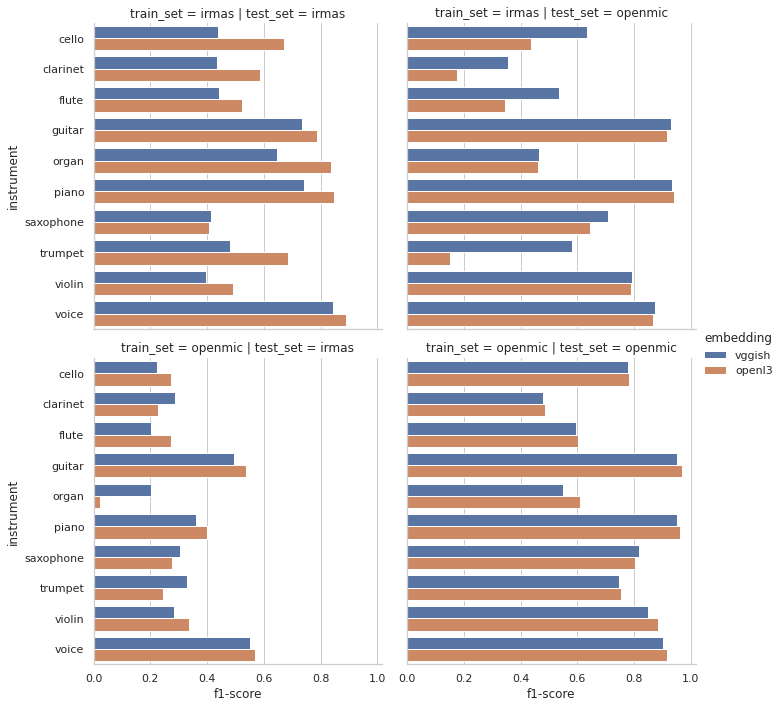

In [42]:
sns.set_theme(context='notebook', style='whitegrid', palette='deep')

df = pd.read_csv('crossdataset_generalization_result_LDAproj.csv')
sns.catplot(data=df, row='train_set', col='test_set', y='instrument', x='f1-score', hue='embedding', kind='bar');
plt.savefig('crossdataset_generalization_f1score_LDAproj.png')

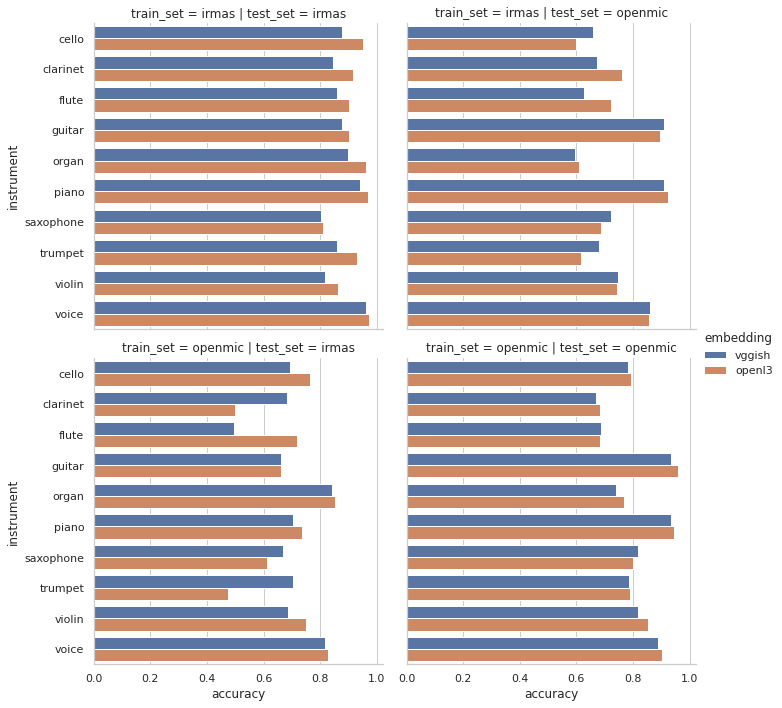

In [43]:
sns.set_theme(context='notebook', style='whitegrid', palette='deep')

df = pd.read_csv('crossdataset_generalization_result_LDAproj.csv')
sns.catplot(data=df, row='train_set', col='test_set', y='instrument', x='accuracy', hue='embedding', kind='bar');
plt.savefig('crossdataset_generalization_accuracy_LDAproj.png')

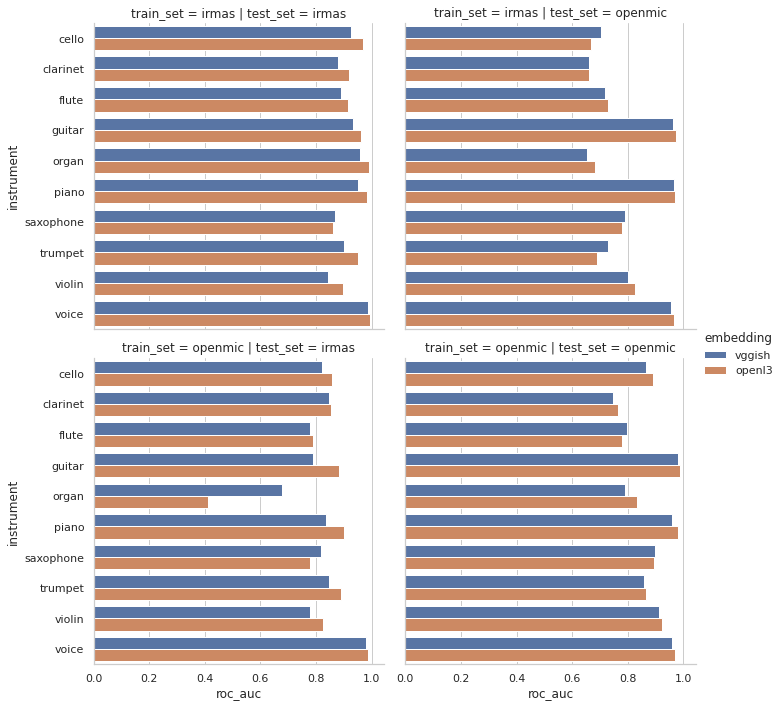

In [40]:
sns.set_theme(context='notebook', style='whitegrid', palette='deep')

df = pd.read_csv('crossdataset_generalization_result_LDAproj.csv')
sns.catplot(data=df, row='train_set', col='test_set', y='instrument', x='roc_auc', hue='embedding', kind='bar');
plt.savefig('crossdataset_generalization_auc_LDAproj.png')

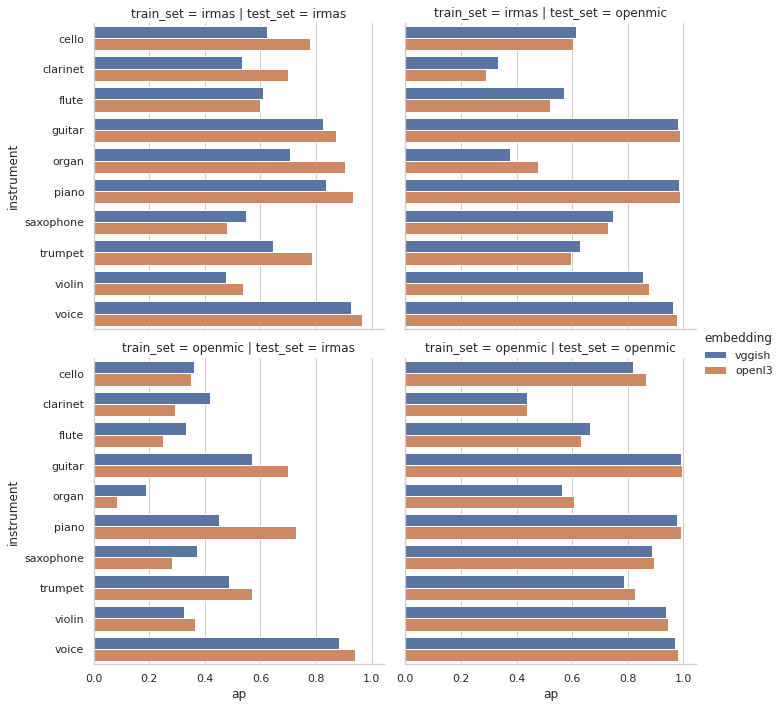

In [41]:
sns.set_theme(context='notebook', style='whitegrid', palette='deep')

df = pd.read_csv('crossdataset_generalization_result_LDAproj.csv')
sns.catplot(data=df, row='train_set', col='test_set', y='instrument', x='ap', hue='embedding', kind='bar');
plt.savefig('crossdataset_generalization_ap_LDAproj.png')